# Hotel Chain Cancellation Rating

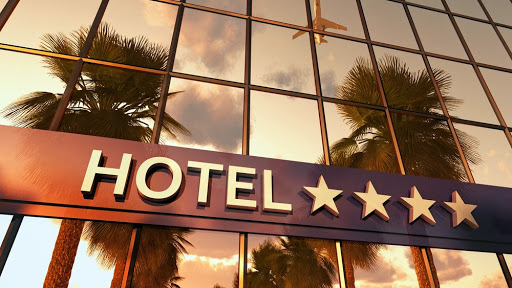

In [7]:
from IPython.display import Image
Image("images/hotel_quatro_estrelas.jpg", width=900)

**Problema de negócio:**

A rede hoteleira espanhola Costa del Data, está com uma alta demanda de cancelamentos de reservas.

A suspeita da diretoria é de que houve uma mudança no comportamento de cancelamentos por parte do consumidor após a pandemia, que ainda não foi compreendida pela rede.

Para compreender esse fenômeno, nós "Only Outliers" fomos contratamos para desenvolver um modelo de previsão de cancelamentos afim de auxiliar o time de marketing tomar decisões mais assertivas.

**Questão de negócio:**

- Entre os clientes que fizeram reservas, quais irão cancelar?

- Relatório com melhores insights de negócio.

**Tópicos mais relevantes**

- A importância da EDA durante a produção projeto.

- Insights de negócio.

- Utilização de Pipelines para organizar a solução.

- Avaliação do modelo.

- Os cincos melhores modelos para gerar o modelo final.

- Próximos passos.

# 1. Importando Bibliotecas e Funções

In [8]:
import numpy as np
import pandas as pd
import sweetviz as sv
import seaborn           as sns
import matplotlib.pyplot as plt

from xgboost                 import XGBClassifier

from sklearn.compose         import ColumnTransformer
from sklearn.impute          import SimpleImputer
from sklearn.metrics         import make_scorer, accuracy_score, f1_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# 2. Carregamento dos dados

In [11]:
path = '/home/jonas/Documentos/repos/hackdays_hotel_cancellation/datasets/'

# Dados de Treino
df_train      = pd.read_csv(path + 'train.csv')

# Dados de Teste
df_test       = pd.read_csv(path + 'test.csv')

# Modelo de Submissão
df_submission = pd.read_csv(path + 'submission.csv')

In [6]:
# configurações globais
sns.set_theme()                                                   # gráfico
plt.rcParams['figure.figsize'] = [20, 12]                         # gráfico

# 3 Descrição dos Dados

## 3.1 Amostra dos Dados

In [7]:
df_train.head()

,id,Classificação do hotel,Meses da reserva até o check-in,Número de pernoites reservadas,Número de hospedes,Regime de alimentação,Nacionalidade,Forma de Reserva,Já se hospedou anterioremente,Tipo do quarto reservado,Reserva feita por agência de turismo,Reserva feita por empresa,Reserva com Estacionamento,Reserva com Observações,Reserva Cancelada
0,33571,5 estrelas,5,5,2.0,Café da manha e jantar,France,Agência,Não,Amethyst,Sim,Não,Sim,Nenhuma,0
1,82458,4 estrelas,167,3,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1
2,94061,4 estrelas,4,3,2.0,Café da manha,Belgium,Agência,Não,Amethyst,Sim,Não,Não,1 a 3,0
3,75196,4 estrelas,13,2,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1
4,82940,4 estrelas,4,2,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1


## 3.2 Colunas

In [8]:
df_train.columns

Index(['id', 'Classificação do hotel', 'Meses da reserva até o check-in',
       'Número de pernoites reservadas', 'Número de hospedes',
       'Regime de alimentação', 'Nacionalidade', 'Forma de Reserva',
       'Já se hospedou anterioremente', 'Tipo do quarto reservado',
       'Reserva feita por agência de turismo', 'Reserva feita por empresa',
       'Reserva com Estacionamento', 'Reserva com Observações',
       'Reserva Cancelada'],
      dtype='object')

## 3.3 Dimensão dos Dados

In [9]:
print(f'Linhas: {df_train.shape[0]}')
print(f'Colunas: {df_train.shape[1]}')

Linhas: 72159
Colunas: 15


## 3.4 Tipos dos Dados

In [10]:
df_train.dtypes

id                                        int64
Classificação do hotel                   object
Meses da reserva até o check-in           int64
Número de pernoites reservadas            int64
Número de hospedes                      float64
Regime de alimentação                    object
Nacionalidade                            object
Forma de Reserva                         object
Já se hospedou anterioremente            object
Tipo do quarto reservado                 object
Reserva feita por agência de turismo     object
Reserva feita por empresa                object
Reserva com Estacionamento               object
Reserva com Observações                  object
Reserva Cancelada                         int64
dtype: object

## 3.5 Checagem de Valores Nulos

In [11]:
df_train.isna().sum()

id                                         0
Classificação do hotel                     0
Meses da reserva até o check-in            0
Número de pernoites reservadas             0
Número de hospedes                         3
Regime de alimentação                      0
Nacionalidade                           1093
Forma de Reserva                           0
Já se hospedou anterioremente              0
Tipo do quarto reservado                   0
Reserva feita por agência de turismo       0
Reserva feita por empresa                  0
Reserva com Estacionamento                 0
Reserva com Observações                    0
Reserva Cancelada                          0
dtype: int64

# 4. Estatística Descritiva e EDA

## 4.1 Análise dos Dados

In [12]:
# Separação das variáveis independentes e dependente
X = df_train.drop(['Reserva Cancelada'], axis=1)
y = df_train['Reserva Cancelada'].copy()

# Separação entre treino(75%) e teste(25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [13]:
my_report = sv.analyze(pd.concat([X_train, y_train], axis=1))
my_report.show_html()

                                             |      | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


**Principais conclusões da análise:**
- ID está altamente correlacionado com: Classificação do Hotel, Regime de Alimentação, Reserva Cancelada, Tipo de Quarto Reservado.
- Outliers nas variáveis: Meses da reserva até check-in, Número de pernoites reservadas, Número de hóspedes
- Nacionalidade: 1,5% de dados Nulos e 48% de Espanhois.
- Algumas colunas estão desbalanceadas: Reserva com estacionamento, Reserva feita por empresa, Reserva feita por agência de turismo.
- 'Forma de Reserva = Agência' não indica que 'Reserva feita por agência de turismo = Sim'
- 'Forma de Reserva = B2B' não indica que 'Reserva feita por empresa = Sim'

## 4.2 Hipóteses de Negócio

### H1: Quanto maior os meses de reserva até o check-in, maior é a chance da reserva ser cancelada.

**Verdadeira.**

**Sugestão:** 
- Limitar a quantidade de meses que se pode fazer a reserva antecipada.

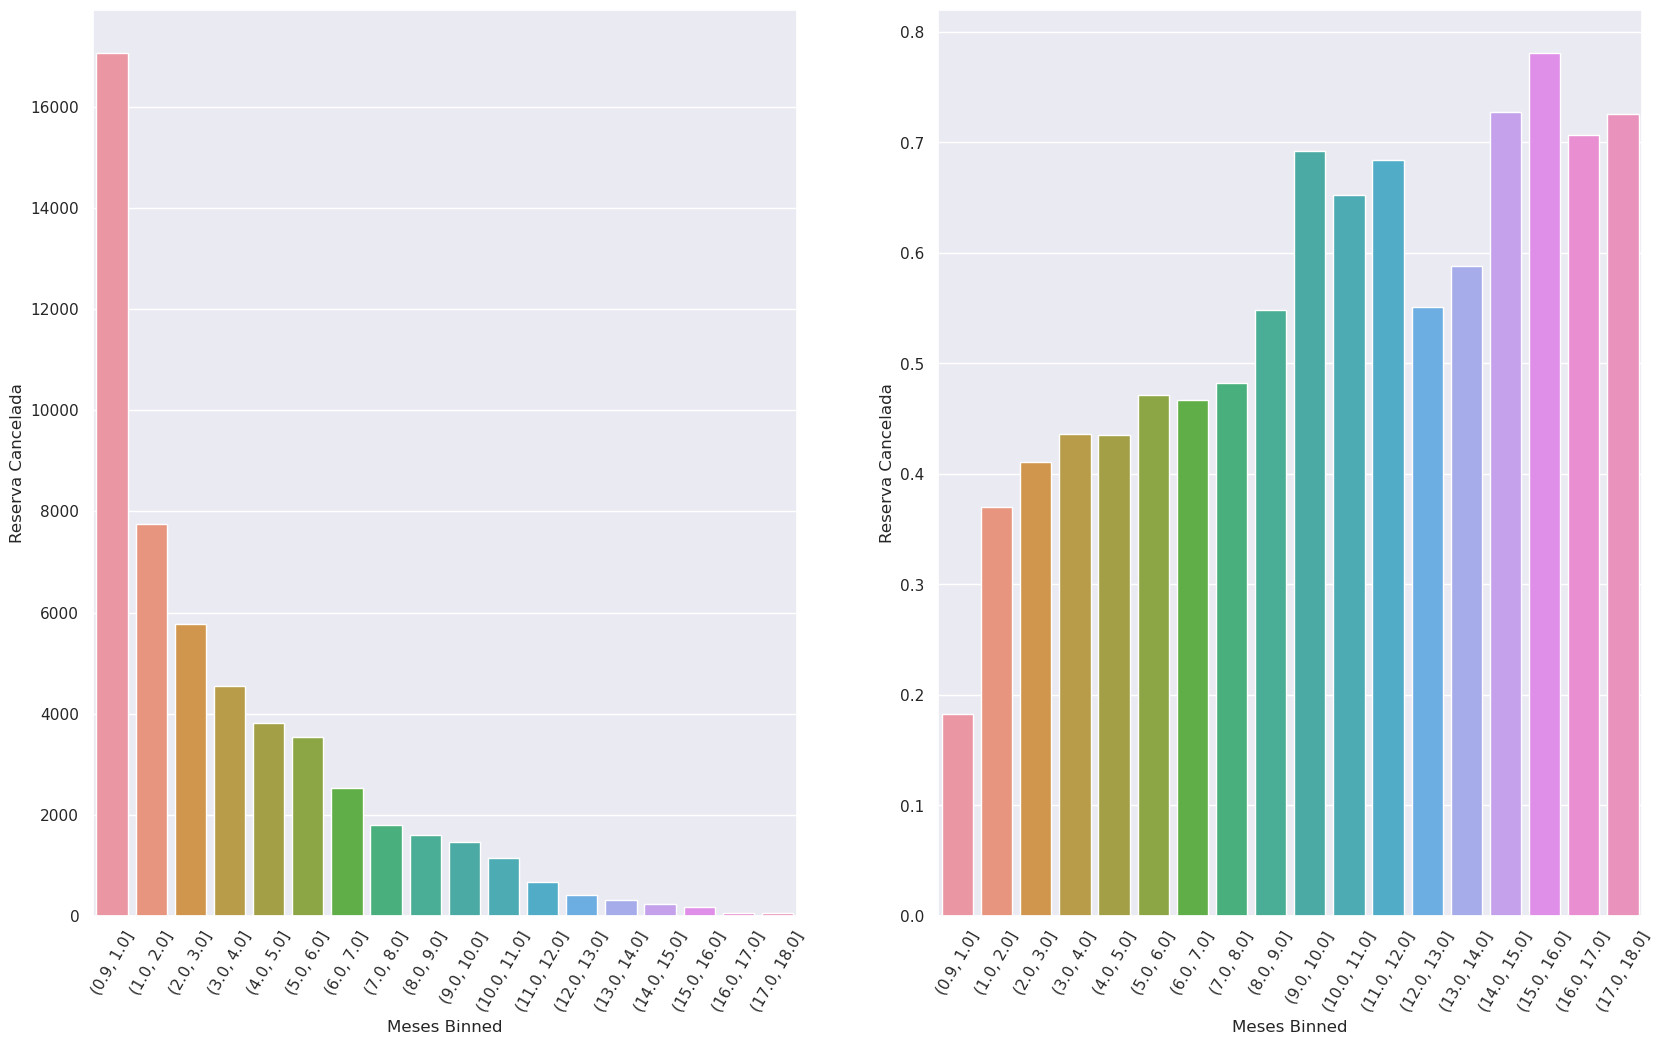

In [52]:
df_hip = pd.concat([X_train, y_train], axis=1)

df_hip['Meses Binned'] = pd.cut(df_hip['Meses da reserva até o check-in'], bins=[0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

df_aux = df_hip[['Meses Binned', 'Reserva Cancelada']].groupby('Meses Binned').count().reset_index()
plt.subplot(1, 2, 1)
sns.barplot(data=df_aux, x='Meses Binned', y='Reserva Cancelada');
plt.xticks(rotation=60);

df_aux2 = df_hip[['Meses Binned', 'Reserva Cancelada']].groupby('Meses Binned').mean().reset_index()
plt.subplot(1, 2, 2)
sns.barplot(data=df_aux2, x='Meses Binned', y='Reserva Cancelada');
plt.xticks(rotation=60);

### H2: Há mais cancelamentos entre clientes que não contratam estacionamento. 

**Verdadeira**

**Sugestões:**
- Oferecer estacionamento.
- Parceria com estacionamentos próximos.

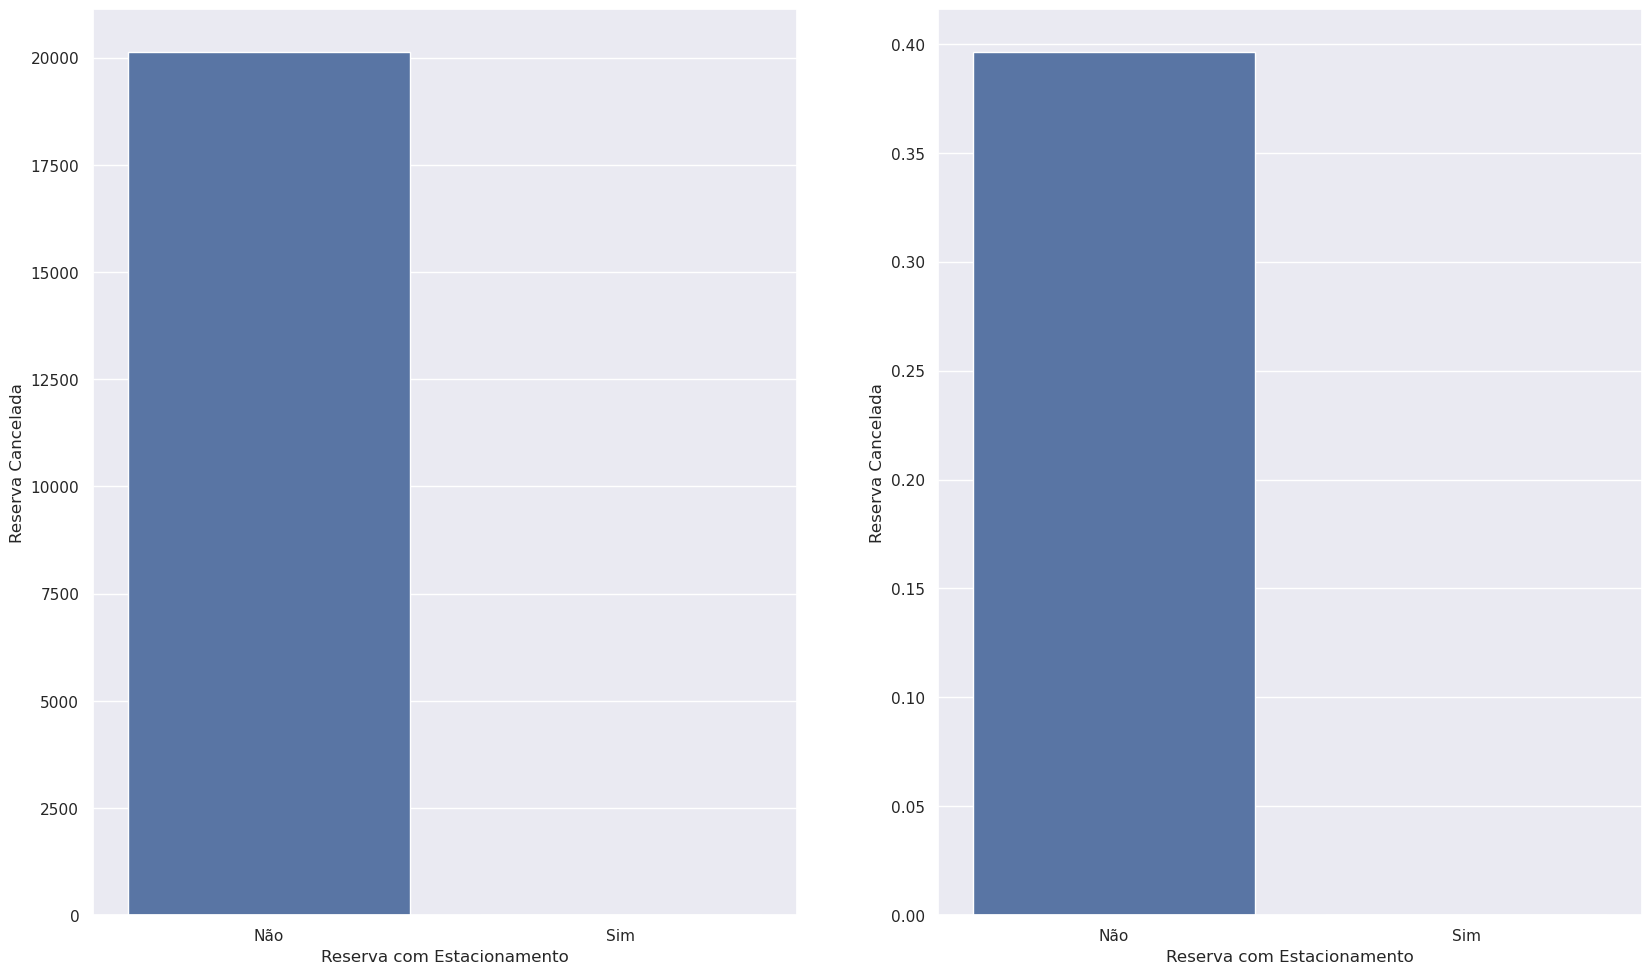

In [53]:
df_aux = df_hip[['Reserva com Estacionamento', 'Reserva Cancelada']].groupby('Reserva com Estacionamento').sum().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(data=df_aux, x='Reserva com Estacionamento', y='Reserva Cancelada')

plt.subplot(1, 2, 2)
df_aux2 = df_hip[['Reserva com Estacionamento', 'Reserva Cancelada']].groupby('Reserva com Estacionamento').mean().reset_index()
sns.barplot(data=df_aux2, x='Reserva com Estacionamento', y='Reserva Cancelada');

### H3: Quanto mais pernoites reservadas, menor a chance de cancelamento.

**Falsa**

**Sugestão:** 
- Não permitir cancelamento gratuito para número de pernoites maiores que 14 dias.

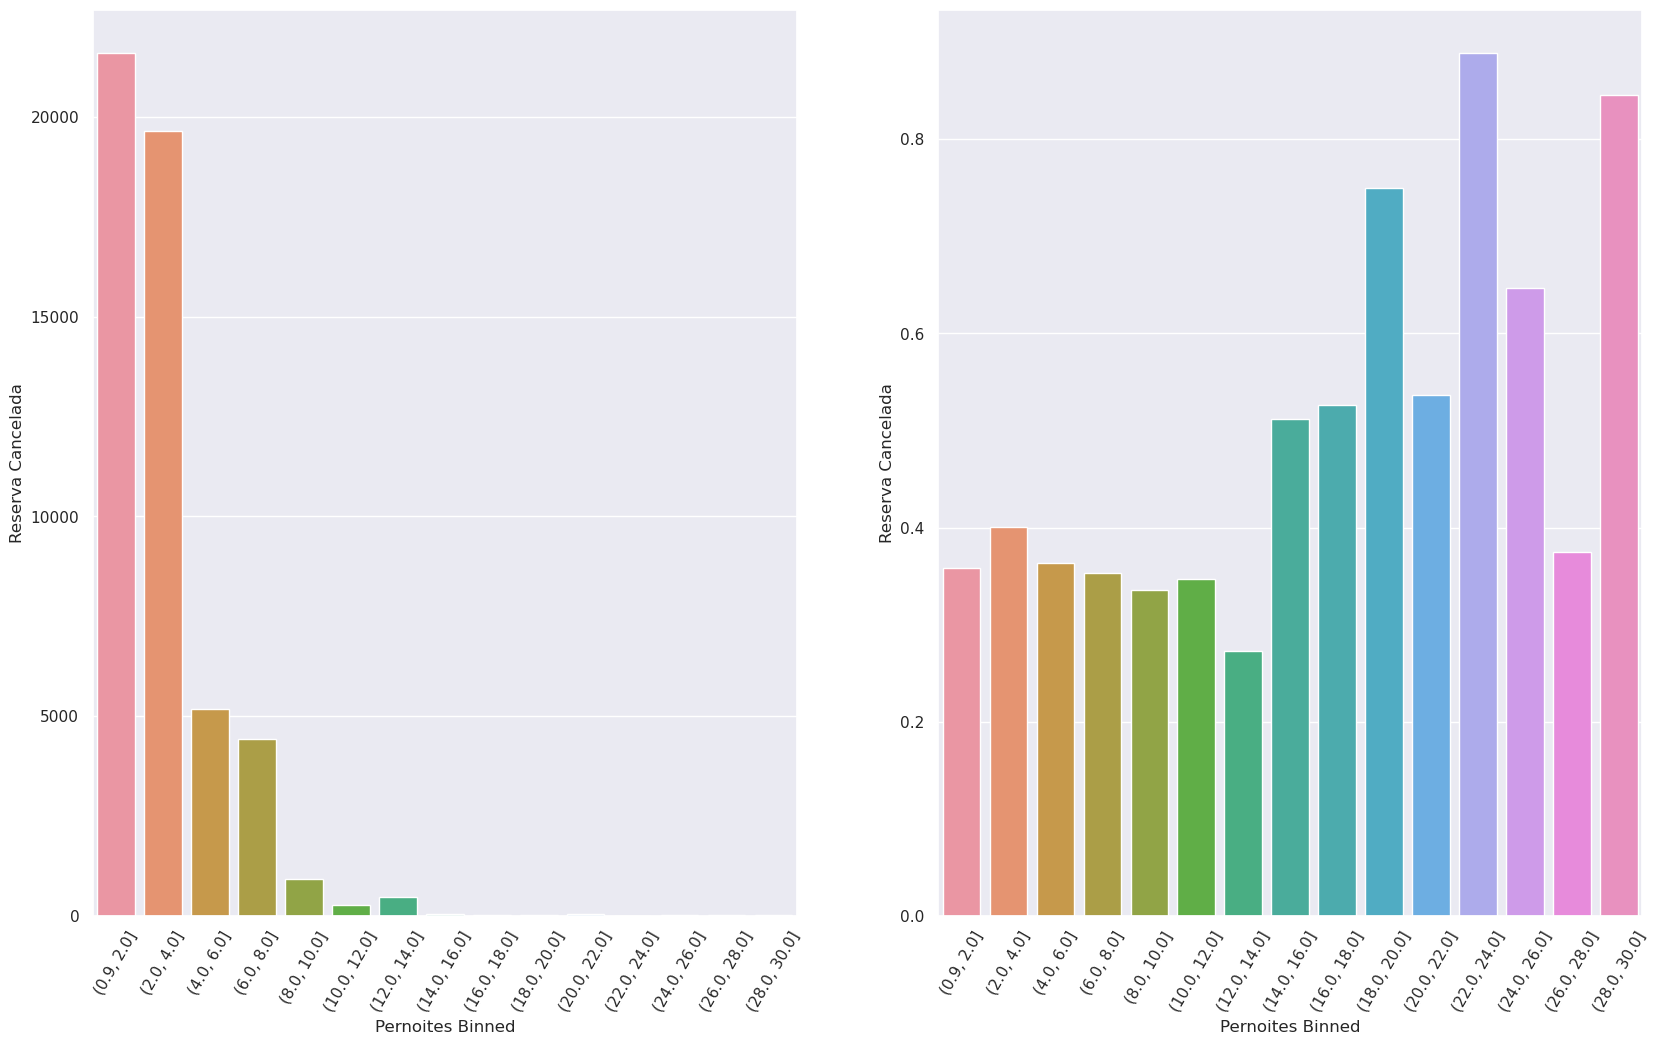

In [54]:
df_hip = pd.concat([X_train, y_train], axis=1)

df_hip['Pernoites Binned'] = pd.cut(df_hip['Número de pernoites reservadas'], bins=[0.9, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])

df_aux = df_hip[['Pernoites Binned', 'Reserva Cancelada']].groupby('Pernoites Binned').count().reset_index()
plt.subplot(1, 2, 1)
sns.barplot(data=df_aux, x='Pernoites Binned', y='Reserva Cancelada');
plt.xticks(rotation=60);

df_aux2 = df_hip[['Pernoites Binned', 'Reserva Cancelada']].groupby('Pernoites Binned').mean().reset_index()
plt.subplot(1, 2, 2)
sns.barplot(data=df_aux2, x='Pernoites Binned', y='Reserva Cancelada');
plt.xticks(rotation=60);

# 5. Preparação dos Dados

In [14]:
# variáveis categóricas
cat_columns = list(X.select_dtypes(include=['object']).columns)

# variáveis numéricas
num_columns  = list(X.select_dtypes(include=['int64', 'float64']).columns)

In [15]:
# pipeline variáveis cateǵoricas
cat_pipe = Pipeline([("cat_imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                     ("ohe"        , OneHotEncoder(handle_unknown="ignore"))])

# pipeline variáveis numéricas
num_pipe = Pipeline([("num_imputer", SimpleImputer(missing_values=np.nan, strategy="median")),
                     ("outliers"   , RobustScaler()),
                     ("scaler"     , StandardScaler())])

# data preparation
preprocessing = ColumnTransformer([("categorica", cat_pipe, cat_columns),
                                   ("numerica", num_pipe, num_columns)])

# 6 Seleção dos Atributos

Todos os atributos foram selecionados para o modelo, inclusive o 'id'.

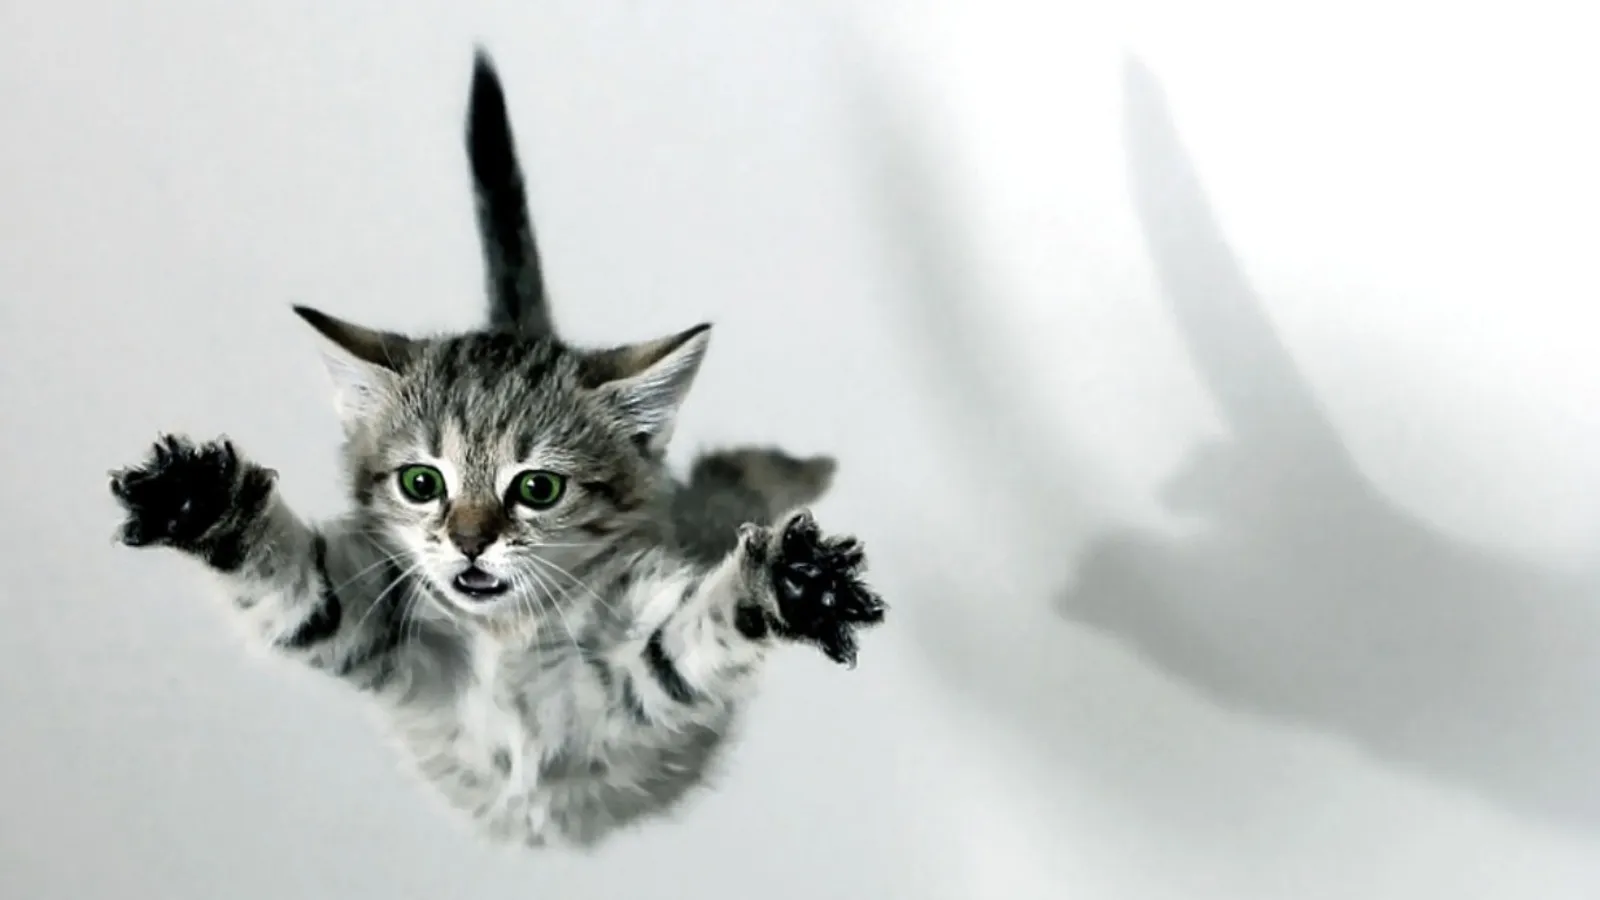

In [16]:
Image("pulo-gato (1).jpg")

# 7. Machine Learning

## 7.1 XGBoost

In [17]:
# pipeline para treinamento
pipe = Pipeline([("preprocessing", preprocessing),
                 ("xgb", XGBClassifier())])

# 8. Otimização dos hiperparâmetros

## 8.1 Treino

In [18]:
# hiperparâmetros
xgb_hyperparams = {"xgb__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15 ],
                   "xgb__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ], 
                   "xgb__min_child_weight" : [ 1, 3, 5, 7 ],
                   "xgb__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
                   "xgb__learning_rate"    : [ 0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] }

# métricas
f1_macro          = make_scorer(f1_score, average="macro")
precision         = make_scorer(precision_score)
recall            = make_scorer(recall_score)
accuracy          = make_scorer(accuracy_score)

scoring_dict = {'f1_macro'          : f1_macro,
                'precision'         : precision,
                'recall'            : recall,
                'accuracy'          : accuracy}



In [19]:
# Randomized Scearch Cross Validation
rscv = RandomizedSearchCV(estimator=pipe,
                          param_distributions=xgb_hyperparams,
                          n_iter = 20,
                          scoring = scoring_dict,
                          refit = 'f1_macro',
                          n_jobs = -1,
                          cv = 5,
                          random_state=42)

In [20]:
# Resultado considerando a métrica principal (f1-score)
result = rscv.fit(X_train, y_train)

print(f'Os melhores parâmetros foram:\n{result.best_params_}')

print(f'\nA melhor média de f1-score foi: {result.best_score_}')

Os melhores parâmetros foram:
{'xgb__min_child_weight': 1, 'xgb__max_depth': 15, 'xgb__learning_rate': 0.2, 'xgb__gamma': 0.4, 'xgb__colsample_bytree': 0.7}

A melhor média de f1-score foi: 0.9705907506824284


In [21]:
# Pipeline do melhor resultado
result.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorica',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Classificação do hotel',
                                                   'Regime de alimentação',
                                                   'Nacionalidade',
                                                   'Forma de Reserva',
                                                   'Já se hospedou '
                                                   'anterioremente',
                                                   'Tipo do quarto reservado',
                                                   'Reserva feita por...
                               gamma=0.4, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.2, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=15, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, ...))])

In [22]:
# Resultado com todas as métricas observadas
df_result = pd.DataFrame(result.cv_results_)

# Selecionando apenas algumas das colunas
df_result[['rank_test_f1_macro',
           'mean_test_f1_macro',
           'std_test_f1_macro',
           'mean_test_precision',
           'std_test_precision',
           'mean_test_recall',
           'std_test_recall',
           'mean_test_accuracy',
           'std_test_accuracy']].sort_values('rank_test_f1_macro').head()

,rank_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy
6,1,0.970591,0.001127,0.966141,0.002320,0.959845,0.002155,0.972560,0.001053
9,2,0.969630,0.001061,0.964146,0.001296,0.959448,0.002967,0.971655,0.000976
15,3,0.969604,0.000836,0.964615,0.002092,0.958901,0.003104,0.971637,0.000766
2,4,0.969445,0.000903,0.963023,0.002413,0.960143,0.001813,0.971470,0.000850
11,5,0.968002,0.000865,0.962430,0.002054,0.957062,0.003706,0.970140,0.000782


|rank| mean_test_f1 | std_test_f1 | mean_test_precision | std_test__precision | mean_test_recall | std_test_recall | mean_test_accuracy | std_test_accuracy |
|-|---------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
|1|	0.970591|	0.001127|	0.966141|	0.002320|	0.959845|	0.002155|	0.972560|	0.001053|
|2|	0.969630|	0.001061|	0.964146|	0.001296|	0.959448|	0.002967|	0.971655|	0.000976|
|3|	0.969604|	0.000836|	0.964615|	0.002092|	0.958901|	0.003104|	0.971637|	0.000766|
|4|	0.969445|	0.000903|	0.963023|	0.002413|	0.960143|	0.001813|	0.971470|	0.000850|
|5|	0.968002|	0.000865|	0.962430|	0.002054|	0.957062|	0.003706|	0.970140|	0.000782|


**Precisão**: Entre os clientes que detectamos que irão cancelar, quantos de fato irão cancelar?

**Recall**: Entre os clientes que irão cancelar, quantos nos detectamos que irão cancelar?

**F1-score**: Média Harmônica entre a Precisão e o Recall.

$$F1score = 2.\frac{Precisão . Recall}{Precisão + Recall}$$

## 8.2 Teste

In [23]:
# Treino com o melhor pipeline
pipe = result.best_estimator_
model = pipe.fit(X_train, y_train)

# Predição para dados nunca vistos
y_hat = model.predict(X_test)

# Métrica para dados não vistos pelo modelo
print(f'O f1-score foi: {f1_score(y_test, y_hat)}')
print(f'A precisão foi: {precision_score(y_test, y_hat)}')
print(f'O recall  foi:  {recall_score(y_test, y_hat)}')
print(f'A acurácia foi: {accuracy_score(y_test, y_hat)}')

O f1-score foi: 0.9634450919548929
A precisão foi: 0.9635180139267333
O recall  foi:  0.9633721810201301
A acurácia foi: 0.9732261640798227


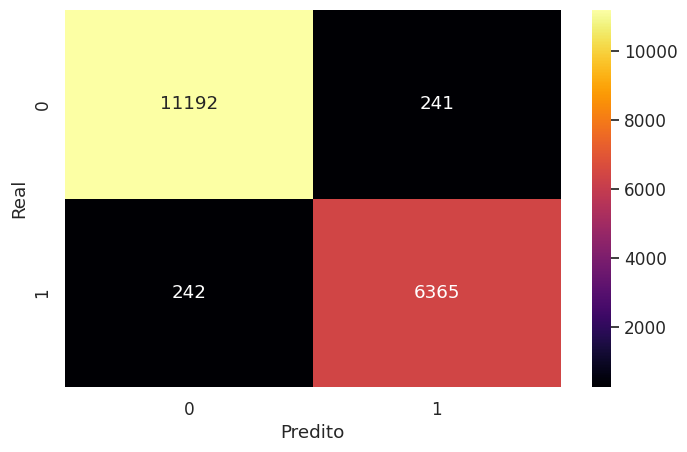

In [24]:
# Matriz de Confusão
cnf_matrix = confusion_matrix(y_test, y_hat)
df_cm = pd.DataFrame(cnf_matrix, columns=np.unique(y_test), index=np.unique(y_test))
df_cm.index.name = 'Real'
df_cm.columns.name = 'Predito'
plt.figure(figsize = (8, 5))
sns.set(font_scale=1.1)
sns.heatmap(df_cm, cbar=True, cmap = 'inferno', annot = True, fmt='.0f');

# 9. Retreino para submissão

In [31]:
# Retreino com o Pipeline do melhor resultado
pipe = result.best_estimator_
model = pipe.fit(X, y)

# predição
y_pred = model.predict(df_test)

In [32]:
# atribuição da predição para coluna 'Reserva Cancelada' da submissão
df_submission['Reserva Cancelada'] = y_pred

# Salva o df_submission em .csv
df_submission.to_csv('datasets/hotel_cancelation.csv', index=False)

# 10. Submissão

Como haviam muitas variações de modelos que estavam performando muito bem, optamos gerar uma resposta baseada nos nossos cinco melhores modelos, da seguinte maneira:

**Exemplo:**

|id         | modelo 1 | modelo 2 | modelo 3 | modelo 4 | modelo 5 | média | modelo final |
|-----------|----------|----------|----------|----------|----------|-------|--------------|
|118345     | 0        | 0        | 0        | 0        | 0        | 0     | 0            |
|9500       | 1        | 1        | 1        | 1        | 1        | 1     | 1            |
|15492	    | 0        | 0        | 0        | 1        | 1        | 0.4   | 0            |
|6443	    | 0        | 0        | 1        | 0        | 0        | 0.2   | 0            |
|49092      | 0        | 1        | 1        | 1        | 1        | 0.8   | 1            |
|48307      | 0        | 1        | 0        | 1        | 1        | 0.6   | 1            |

# 11. Próximos Passos

- Entender o que está por trás do 'id', possibilitando extrair a features que compõem o 'id'.
- Implementar o modelo na etapa de cadastro do cliente na plataforma de reserva, dessa forma quando o cliente finalizar o cadastro já saberemos se ele tem mais chance de cancelar ou não, assim podemos limitar as possibilidades de cancelamento. Exemplo: multa para cancelamento; período de cancelamento gratuito menor do que o padrão.
- Configurar disparos de e-mails automáticos direcionados aos clientes com maior probabilidade de cancelamento.
- Solicitar dados monetários para monitorar as ações tomadas e retomar os projetos de expansão da rede.